In [1]:
import numpy as np
import csv
import os
from datetime import datetime, timedelta


FUNÇÕES AUXILIARES
Antes de começar a falar sobre o código é importante entender que em análises financeiras será necessário trabalhar com diversas mudanças de datas, arredondamentos, feriados e conversões de taxas, para isso é importante você criar algumas funções auxiliares para usar durante o caminho.
O primeiro passo é ter o calendário de feriados bancários da ANBIMA, isso é extremamente importante pois os títulos tem rendimentos atrelados aos dias úteis do ano.
Em seguida eu criei algumas funções que trabalham com datas, eu chamei esse arquivo de "calendario.py":

In [2]:
def adicionar_dias_uteis(data, dias):
    for dia in range(dias):
        data = adicionar_dias_corridos(data=data, dias=1)

        while not np.is_busday(dates=data, weekmask='1111100', holidays=feriados):
            data = adicionar_dias_corridos(data=data, dias=1)

    return data


def remover_dias_uteis(data, dias):
    for dia in range(dias):
        data = remover_dias_corridos(data=data, dias=1)

        while not np.is_busday(dates=data, weekmask='1111100', holidays=feriados):
            data = remover_dias_corridos(data=data, dias=1)

    return data


def adicionar_dias_corridos(data, dias):
    nova_data = datetime.strptime(data, "%Y-%m-%d") + timedelta(days=dias)
    return nova_data.strftime("%Y-%m-%d")


def remover_dias_corridos(data, dias):
    nova_data = datetime.strptime(data, "%Y-%m-%d") - timedelta(days=dias)
    return nova_data.strftime("%Y-%m-%d")


def coverte_formato_data(data):
    return f'{data[-4:]}-{data[3:5]}-{data[:2]}'


def calcula_dias_uteis(data_inicio, data_fim):
    return np.busday_count(begindates=data_inicio, enddates=data_fim, weekmask='1111100', holidays=feriados) + 1


def carregar_feriados():
    feriados = []
    with open(f'{os.path.dirname(__file__)}/../dados_externos/feriados_nacionais.csv', newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=';')
        for row in spamreader:
            feriados.append(coverte_formato_data(data=row[0]))

    return feriados


feriados = carregar_feriados()

NameError: ignored

Outra coisa muito importante é saber qual o método correto de arredondamento/truncamento dos valores decimais em finanças, eu costumo utilizar o caderno de fórmulas da B3. Eu chamei esse arquivo de "formulas.py":

In [ ]:
import math


def truncar(numero, decimais):
    if type(numero) == int:
        return numero

    splitted_number = str(numero).split('.')
    return float(f'{splitted_number[0]}.{splitted_number[1][:decimais]}')


def arredondar_para_cima(numero, decimais=2):
    if not isinstance(decimais, int):
        raise TypeError("decimal places must be an integer")
    elif decimais < 0:
        raise ValueError("decimal places has to be 0 or more")
    elif decimais == 0:
        return math.ceil(numero)

    factor = 10 ** decimais
    return math.ceil(numero * factor) / factor


def calcula_valor_nominal_juros_compostos(valor_investido, taxa, periodo):
    valor_nominal = valor_investido * ((1 + taxa) ** periodo)
    return round(valor_nominal, 2)


def converte_tx_ano_para_dia(taxa):
    taxa_convertida = ((1 + taxa) ** (1 / 252)) - 1
    return truncar(numero=taxa_convertida, decimais=2)


def converte_taxa_ano_para_semestre(taxa):
    return ((1 + taxa) ** (1 / 2)) - 1

Agora que temos essas funções para nos auxiliar, vamos entender o cálculo dos títulos.
TESOURO PREFIXADO ZERO CUPOM
Vamos começar com o Tesouro Prefixado sem pagamento de cupom.

In [ ]:
from funcoes_auxiliares import calendario, formulas


class TesouroPrefixado:
    def __init__(self, data_compra, data_vencimento, valor_investido, rentabilidade_anual, preco_unitario=None):
        self.data_compra = data_compra
        self.data_vencimento = data_vencimento
        self.valor_investido = valor_investido
        self.rentabilidade_anual = rentabilidade_anual
        self.preco_unitario = preco_unitario if preco_unitario else self.calcular_preco_unitario()

    def calcular_preco_unitario(self):
        data_compra = calendario.coverte_formato_data(self.data_compra)
        data_vencimento = calendario.coverte_formato_data(self.data_vencimento)
        dias_uteis = calendario.calcula_dias_uteis(data_inicio=data_compra, data_fim=data_vencimento)
        preco_unitario = 1000 / ((1 + self.rentabilidade_anual) ** (dias_uteis / 252))
        preco_unitario = formulas.truncar(numero=preco_unitario, decimais=2)

        return preco_unitario

    def calcular_valor_nominal(self):
        valor_nominal = (self.valor_investido / self.preco_unitario) * 1000
        valor_nominal = formulas.arredondar_para_cima(numero=valor_nominal, decimais=2)

        return valor_nominal


if __name__ == '__main__':
    titulo_1 = TesouroPrefixado(
        data_compra='19/03/2021',
        data_vencimento='01/09/2024',
        valor_investido=788.66,
        rentabilidade_anual=0.0754
    )
    titulo_1_valor_nominal = titulo_1.calcular_valor_nominal()
    print(titulo_1_valor_nominal)

# O preço de qualquer instrumento financeiro é igual ao valor presente de seu fluxo de caixa esperado. Considerando o valor nominal dos títulos prefixados de R$1000, a fórmula de cálculo do preço unitário desses papéis é:

![image.png](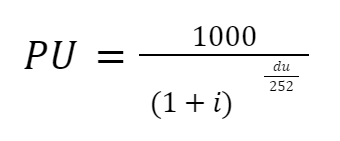
)

Onde:   
PU = preço unitário do título; 
du = dias úteis entre a data de liquidação (inclusive) e a data de vencimento (exclusive);   
i = taxa do papel na compra
Com o valor do preço unitário calculado, para descobrir o valor nominal que você receberá do título basta realizar a seguinte conta:
Não foi fornecido texto alternativo para esta imagem

TESOURO PREFIXADO COM CUPOM
O tesouro prefixado com cupom possui um fluxo de pagamento de juros semestrais, 01/janeiro e 01/julho, o pagamento dos cupons tem um cálculo um tanto complexo, com base em predeterminações do próprio Tesouro.
Mas o retorno do cupom é na verdade de 4,88% a cada seis meses. Assim, a cada R$ 1.000 investidos, você recebe R$ 48,80 no pagamento semestral do título prefixado. O que equivale à 10% do valor de face do título, fixado em R$ 1.000.
Não foi fornecido texto alternativo para esta imagem
O primeiro passo é descobrir quais as datas dos próximos pagamento de cupom do título:
Não foi fornecido texto alternativo para esta imagem
O preço unitário desse título corresponde ao valor presente de seu fluxo de pagamentos, descontado pela taxa de retorno que se pretender obter no investimento. Cabe destacar contudo, que o fluxo de caixa de cada parcela é descontado contemplando o número de dias úteis entra a data de liquidação e seu respectivo pagamento.
Não foi fornecido texto alternativo para esta imagem
Por fim com o preço unitário calculado podemos descobrir o valor nominal, somando o valor nominal do título e o valor bruto dos cupons:
Não foi fornecido texto alternativo para esta imagem
Por hoje é isso, se você gostou do artigo por favor clique em "Gostei" para ajudar na divulgação e qualquer sugestão, crítica e, claro, elogios fique a vontade. 


In [ ]:
from funcoes_auxiliares import calendario, formulas
from datetime import datetime


class TesouroPrefixadoComJurosSemetrais:
    def __init__(self, data_compra, data_vencimento, valor_investido, rentabilidade_anual, preco_unitario=None):

        self.data_compra = data_compra
        self.data_vencimento = data_vencimento
        self.valor_investido = valor_investido
        self.rentabilidade_anual = rentabilidade_anual
        self.datas_pagamento_cupom, self.dias_uteis = self.descobrir_datas_pagamento_cupom()
        self.preco_unitario = preco_unitario if preco_unitario else self.calcular_preco_unitario()

    def calcular_preco_unitario(self):
        preco_unitario = 0
        for dia in self.dias_uteis[:-1]:
            preco_unitario += 48.81 / ((1 + self.rentabilidade_anual) ** (dia / 252))
        preco_unitario += (1000 + 48.81) / ((1 + self.rentabilidade_anual) ** (dia / 252))
        preco_unitario = formulas.truncar(numero=preco_unitario, decimais=2)

        return preco_unitario

    def descobrir_datas_pagamento_cupom(self):
        data_compra_timestamp = datetime.strptime(self.data_compra, "%d/%m/%Y")
        data_vencimento_timestamp = datetime.strptime(self.data_vencimento, "%d/%m/%Y")

        datas_pagamento_cupom = []
        if 1 < data_compra_timestamp.month < 7:
            for ano in range(data_compra_timestamp.year, data_vencimento_timestamp.year):
                datas_pagamento_cupom.append(f"{ano}-07-01")
                datas_pagamento_cupom.append(f"{ano + 1}-01-01")
        else:
            for ano in range(data_compra_timestamp.year, data_vencimento_timestamp.year):
                datas_pagamento_cupom.append(f"{ano + 1}-01-01")
                datas_pagamento_cupom.append(f"{ano + 1}-07-01")

        if data_vencimento_timestamp.month > 1:
            datas_pagamento_cupom.pop(-1)

        dias_uteis = []
        data_compra = calendario.coverte_formato_data(self.data_compra)
        for dia_de_pagamento in datas_pagamento_cupom:
            dias_uteis.append(calendario.calcula_dias_uteis(data_inicio=data_compra, data_fim=dia_de_pagamento))

        return datas_pagamento_cupom, dias_uteis

    def calcular_valor_nominal(self):
        # taxa_cupom = formulas.converte_taxa_ano_para_semestre(taxa=0.10)
        # taxa_cupom = formulas.truncar(numero=taxa_cupom, decimais=4)
        taxa_cupom = 0.04881
        valor_cupom = ((self.valor_investido / self.preco_unitario) * taxa_cupom) * 1000
        valor_cupom = formulas.truncar(numero=valor_cupom, decimais=2)

        valor_bruto_cupons = valor_cupom * len(self.datas_pagamento_cupom)
        valor_nominal = ((self.valor_investido / self.preco_unitario) * 1000) + valor_bruto_cupons
        valor_nominal = formulas.arredondar_para_cima(numero=valor_nominal, decimais=2)
        return valor_nominal


if __name__ == '__main__':
    titulo_1 = TesouroPrefixadoComJurosSemetrais(
        data_compra='27/03/2021',
        data_vencimento='01/01/2031',
        valor_investido=5000,
        rentabilidade_anual=0.0918,
        preco_unitario=1074.95,
    )
    titulo_1_valor_nominal = titulo_1.calcular_valor_nominal()
    print(titulo_1_valor_nominal)